In [4]:
import analyzer
import time
import pandas as pd
%run analyzer.py mnist_nets/mnist_relu_3_10.txt mnist_images/img0.txt 0.0005

verified
analysis time:  0.5211946964263916  seconds


In [5]:
from slope_reduction_v1 import *

In [15]:
def relu_split(model, layer_k, dim_m, h_lb, h_ub, x_lb, x_ub, h_km):
    assert h_lb <= h_ub
    assert x_lb <= x_ub
    assert x_lb >= 0
    
    x_km = model.addVar(vtype=GRB.CONTINUOUS, name="x_"+str(layer_k)+'_' +str(dim_m))
    
    if h_lb >= 0:
        C0 = model.addLConstr(x_km == h_km)
        constraints = [C0]
        flag = 1

    else:
        assert x_lb >= 0
        assert x_ub >= 0
        assert x_ub <= h_ub
    
        slope = x_ub / (x_ub - h_lb)
        intercept = -slope * h_lb
        assert intercept > 0
        
        C0 = model.addLConstr(x_km >= 0)
        C1 = model.addLConstr(x_km >= h_km)
        C2 = model.addLConstr(x_km <= slope * h_km + intercept)
        constraints = [C0,C1,C2]
        flag = 2
        
    return x_km, flag, constraints

In [16]:
def check_ub_convergence(x_ub, xu_old, abs_tol, rel_tol):
    if (xu_old - x_ub < abs_tol):
        #print('abs ub')
        return True
    if x_ub < 1e-5 or xu_old < 1e-5:
        x_ub = 0
        #print('0 ub')
        return True
    
    if (xu_old - x_ub)/xu_old < rel_tol:
        #print('rel ub')
        return True
    return False

In [19]:
def check_lb_convergence(x_lb, xl_old, abs_tol, rel_tol):
    if x_lb == 0:
        return True
    if (x_lb - xl_old  < abs_tol):
        #print('abs lb')
        return True
    if (x_lb - xl_old )/x_lb < rel_tol:
        #print('rel lb')
        return True
    return False

In [25]:
def tighten_bounds(model, x_km, flag, xl_old, xu_old, h_lb, h_km, constraints, abs_tol = 0.005, rel_tol = 0.05):  
    #Stable RELU case
    if len(constraints) == 1:
        model.reset()
        model.setObjective(x_km, GRB.MAXIMIZE)
        model.optimize()
        x_ub = x_km.X
        
        model.reset()
        model.setObjective(x_km, GRB.MINIMIZE)
        model.optimize()
        x_lb = x_km.X
        return x_lb, x_ub
    
    #RELU-Triangle case
    assert len(constraints) == 3
    model.reset()
    converged = False
    while not converged:
        model.setObjective(x_km, GRB.MAXIMIZE)
        model.optimize()
        x_ub = x_km.X
        
        if x_ub < 0.005:
            model.remove(constraints[0])
            model.remove(constraints[1])
            model.remove(constraints[2])
            model.addLConstr(x_km == 0)
            model.update()
            print('removed')
            x_ub = 0
            return 0, 0  #In this case both lower and upper bound ==0
        
        else: #slope update
            new_slope = x_ub / (x_ub - h_lb)
            new_intercept = -new_slope * h_lb
            assert new_intercept > 0
            model.remove(constraints[2])
            constraints[2] = model.addLConstr(x_km <= new_slope * h_km + new_intercept)
            #constraints[2].setAttr('rhs', new_slope * h_km + new_intercept)
            model.update()
        
        #Convergence check
        converged = check_ub_convergence(x_ub, xu_old, abs_tol, rel_tol)
        xu_old = x_ub
    
    #Find lower bound
    model.reset()
    converged = False
    while not converged:
        model.setObjective(x_km, GRB.MINIMIZE)
        model.optimize()
        x_lb = x_km.X
        
        #Convergence check
        converged = check_lb_convergence(x_ub, xu_old, abs_tol, rel_tol)
        xu_old = x_ub
        
    return x_lb, x_ub
        

In [42]:
def optimize_layer_l(layer_k, nn, iobj, model, varis, label): 
    '''Optimizes layer_k '''
    # Inits
    relu_bin = {'zero':0, 'lin':0, 'unstable':0, 'aff':0}
    
    # Get weights, biases & layertype from nn
    layer_type = nn.layertypes[layer_k-1]
    weights = np.array(nn.weights[layer_k-1])
    biases = np.array(nn.biases[layer_k-1])
    
    # Input and output dimensions for the k-th layer
    in_dim  = weights.shape[1]
    out_dim = weights.shape[0]
    
    # Get interval bounds from intervall object to calculate slope and intercept
    hl, hu = iobj.get_logit_bounds(layer_k-1)
    xl, xu = iobj.get_bounds(layer_k)
    assert hl.size == out_dim
    assert xl.size == out_dim       # The x's are ReLU(h)
    
    for dim_m in range(out_dim):
        ws = weights[dim_m,:]  #one row of weights
        b  = biases[dim_m]
        
        if xu[dim_m] <= 0:
            h_km = None
            varis['x_'+str(layer_k)+'_'+str(dim_m)] = 0 
            relu_bin['zero'] +=1
            
        else:    
            # Perform affine transform:  x_kn --> h_km where n iterates over input and m over output dimension
            h_km = LinExpr(b)
            for dim_n in range(in_dim):
                h_km.add( ws[dim_n] * varis['x_'+str(layer_k-1)+'_'+str(dim_n)] )

            # Activation
            if layer_type == 'ReLU':
                x_km, flag, constraints = relu_split(model, layer_k, dim_m, 
                                          h_lb=hl[dim_m], h_ub=hu[dim_m], x_lb=xl[dim_m], x_ub=xu[dim_m], 
                                          h_km=h_km)
        
                if flag == 1:
                    relu_bin['lin'] +=1
                elif flag == 2:
                    relu_bin['unstable'] +=1
            else: #Affine case
                x_km = h_km
                relu_bin['aff']+=1
     
            varis['x_'+str(layer_k)+'_'+str(dim_m)] = x_km 
        
            #TIGHTEN STEP (Only for layers btw 1 & final)
            if layer_k > 1 and layer_k < nn.numlayer:  #For first layer (1) this would just return box. 
                out_ws = np.array(nn.weights[layer_k])[:,dim_m]
                max_out_weight = max(abs(out_ws))
                
                new_lb, new_ub = tighten_bounds(model, x_km, flag, xl[dim_m], xu[dim_m], hl[dim_m], h_km, constraints,
                                               abs_tol= layer_k/(5*max_out_weight*len(out_ws)) )
            
                assert new_lb >= xl[dim_m] - 1e-7
                assert new_ub <= xu[dim_m] + 1e-7

                #UPDATE Layer k
                iobj.intervals['xl_'+str(layer_k)][dim_m] = new_lb
                iobj.intervals['xu_'+str(layer_k)][dim_m] = new_ub
    
    #Final layer verification
    could_still_work = True
    if layer_k == (nn.numlayer):
        corr_label = varis['x_'+str(layer_k)+'_'+str(label)]
        
        for out_digit in range(10):
            if varis['x_'+str(layer_k)+'_'+str(out_digit)] is not corr_label:
                incorr_label = varis['x_' + str(layer_k) + '_' + str(out_digit)]
                
                model.reset()
                model.setObjective(corr_label - incorr_label, GRB.MINIMIZE)
                model.optimize()
                print(corr_label)
                print(incorr_label)

                if corr_label.X - incorr_label.X <= 0:
                    could_still_work = False
                    break
    
    return relu_bin, could_still_work

In [50]:
def optimize_layer_l(layer_k, nn, iobj, model, varis, label): 
    '''Optimizes layer_k '''
    # Inits
    relu_bin = {'zero':0, 'lin':0, 'unstable':0, 'aff':0}
    
    # Get weights, biases & layertype from nn
    layer_type = nn.layertypes[layer_k-1]
    weights = np.array(nn.weights[layer_k-1])
    biases = np.array(nn.biases[layer_k-1])
    
    # Input and output dimensions for the k-th layer
    in_dim  = weights.shape[1]
    out_dim = weights.shape[0]
    
    # Get interval bounds from intervall object to calculate slope and intercept
    hl, hu = iobj.get_logit_bounds(layer_k-1)
    xl, xu = iobj.get_bounds(layer_k)
    assert hl.size == out_dim
    assert xl.size == out_dim       # The x's are ReLU(h)
    
    for dim_m in range(out_dim):
        ws = weights[dim_m,:]  #one row of weights
        b  = biases[dim_m]
        
        if xu[dim_m] <= 0:
            h_km = None
            varis['x_'+str(layer_k)+'_'+str(dim_m)] = 0 
            relu_bin['zero'] +=1
            
        else:    
            # Perform affine transform:  x_kn --> h_km where n iterates over input and m over output dimension
            h_km = LinExpr(b)
            for dim_n in range(in_dim):
                h_km.add( ws[dim_n] * varis['x_'+str(layer_k-1)+'_'+str(dim_n)] )

            # Activation
            if layer_type == 'ReLU':
                x_km, flag, constraints = relu_split(model, layer_k, dim_m, 
                                          h_lb=hl[dim_m], h_ub=hu[dim_m], x_lb=xl[dim_m], x_ub=xu[dim_m], 
                                          h_km=h_km)
        
                if flag == 1:
                    relu_bin['lin'] +=1
                elif flag == 2:
                    relu_bin['unstable'] +=1
            else: #Affine case
                x_km = h_km
                relu_bin['aff']+=1
     
            varis['x_'+str(layer_k)+'_'+str(dim_m)] = x_km 
        
            #TIGHTEN STEP (Only for layers btw 1 & final)
            if layer_k > 1 and layer_k < nn.numlayer:  #For first layer (1) this would just return box. 
                out_ws = np.array(nn.weights[layer_k])[:,dim_m]
                max_out_weight = max(abs(out_ws))
                
                new_lb, new_ub = tighten_bounds(model, x_km, flag, xl[dim_m], xu[dim_m], hl[dim_m], h_km, constraints,
                                               abs_tol= layer_k**3/(100*max_out_weight*len(out_ws)) )
            
                assert new_lb >= xl[dim_m] - 1e-7
                assert new_ub <= xu[dim_m] + 1e-7

                #UPDATE Layer k
                iobj.intervals['xl_'+str(layer_k)][dim_m] = new_lb
                iobj.intervals['xu_'+str(layer_k)][dim_m] = new_ub
    
    #Final layer verification
    could_still_work = True
    if layer_k == (nn.numlayer):
        corr_label = varis['x_'+str(layer_k)+'_'+str(label)]
        
        for out_digit in range(10):
            if varis['x_'+str(layer_k)+'_'+str(out_digit)] is not corr_label:
                incorr_label = varis['x_' + str(layer_k) + '_' + str(out_digit)]
                
                model.reset()
                model.setObjective(corr_label - incorr_label, GRB.MINIMIZE)
                model.optimize()
                print(corr_label)
                print(incorr_label)

                if corr_label.X - incorr_label.X <= 0:
                    could_still_work = False
                    break
    
    return relu_bin, could_still_work

In [234]:
def analyze_v1(netname, epsilon, specname, iobj= None):
    verified = False
    #Import and parse the net
    with open(netname, 'r') as netfile:
        netstring = netfile.read()
    with open(specname, 'r') as specfile:
        specstring = specfile.read()
    nn = parse_net(netstring)
    x0_low, x0_high = parse_spec(specstring)
    LB_N0, UB_N0 = get_perturbed_image(x0_low,0)
    label, _ = analyze(nn,LB_N0,UB_N0,0)
    LB_N0, UB_N0 = get_perturbed_image(x0_low,epsilon)
    assert(LB_N0.shape == UB_N0.shape)
    
    #Set up variable, expression dictionarys & relu case counter
    varis = {}
    relu_bins = {}

    #First box pass
    if iobj is None:
        iobj = interval_object(LB_N0, UB_N0)
        iobj.fit(nn)
    if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, relu_bins, 0, label
    
    #set up gurobi model
    model = Model("net")
    model.setParam('OutputFlag', False)

    # Set up initial input variables & ranges for input image
    for dim_n in range(len(LB_N0)):
        x_0n  = model.addVar(LB_N0[dim_n], UB_N0[dim_n], name="x_0_"+str(dim_n))
        # Add the input variables to variable dict for later access under name x_0_n
        varis['x_0_'+str(dim_n)] = x_0n
        
    # Add 1st layer to model
    relu_bins[1], flag = optimize_layer_l(1, nn, iobj, model, varis, label)
    
    for layer_k in range(2, nn.numlayer):
        #print('--', layer_k, '--')
        #print_lower_upper(iobj.get_bounds(layer_k)[0][:10],iobj.get_bounds(layer_k)[1][:10])
        #print('------------')
        
        relu_bins[layer_k], flag = optimize_layer_l(layer_k, nn, iobj, model, varis, label)
        iobj.fit(nn,layer_k)
        if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, relu_bins, layer_k, label
        
        #print('--', layer_k, ' finished--')
        #print_lower_upper(iobj.get_bounds(layer_k)[0][:10],iobj.get_bounds(layer_k)[1][:10])
        #print('------------')
        #print_lower_upper(*iobj.get_bounds(nn.numlayer))
    
    relu_bins[nn.numlayer], flag = optimize_layer_l(nn.numlayer, nn, iobj, model, varis, label)
    return flag, iobj, relu_bins, layer_k, label
    

In [52]:
netname = 'mnist_nets/mnist_relu_6_100.txt'
epsilon = 0.01
specname = 'mnist_images/img0.txt'

In [53]:
%%time
verf, iobj, relu_bins, layer_k, label = analyze_v1(netname, epsilon, specname)
print(verf, label, layer_k)
print(relu_bins)

-- 2 --
[0.00,	 0.00]
[0.00,	 0.81]
[0.00,	 1.09]
[0.00,	 0.17]
[2.43,	 4.61]
[0.00,	 0.00]
[0.00,	 1.05]
[0.00,	 1.22]
[2.39,	 4.56]
[0.00,	 0.00]
------------
removed
removed
-- 2  finished--
[0.00,	 0.00]
[0.00,	 0.32]
[0.00,	 0.55]
[0.00,	 0.01]
[3.16,	 3.89]
[0.00,	 0.00]
[0.00,	 0.45]
[0.18,	 0.73]
[3.12,	 3.81]
[0.00,	 0.00]
------------
[0.00,	 45.82]
[0.00,	 61.42]
[0.00,	 61.27]
[0.00,	 54.55]
[0.00,	 55.98]
[0.00,	 53.50]
[0.00,	 42.37]
[0.00,	 66.55]
[0.00,	 53.07]
[0.00,	 71.22]
-- 3 --
[0.00,	 1.35]
[0.00,	 0.60]
[0.00,	 0.00]
[0.00,	 0.00]
[0.00,	 0.28]
[0.00,	 0.45]
[0.00,	 0.45]
[0.00,	 0.00]
[0.00,	 1.31]
[0.00,	 0.02]
------------
-- 3  finished--
[0.28,	 0.87]
[0.00,	 0.14]
[0.00,	 0.00]
[0.00,	 0.00]
[0.00,	 0.04]
[0.00,	 0.09]
[0.00,	 0.07]
[0.00,	 0.00]
[0.11,	 0.76]
[0.00,	 0.01]
------------
[0.00,	 12.24]
[0.00,	 17.95]
[0.00,	 16.77]
[0.00,	 16.74]
[0.00,	 15.39]
[0.00,	 14.46]
[0.00,	 9.55]
[0.00,	 30.12]
[0.00,	 12.69]
[0.00,	 22.20]
-- 4 --
[0.00,	 0.00]
[

In [54]:
netname = 'mnist_nets/mnist_relu_6_100.txt'
epsilon = 0.01
specname = 'mnist_images/img1.txt'

In [55]:
%%time
verf, iobj, relu_bins, layer_k, label = analyze_v1(netname, epsilon, specname)
print(verf, label, layer_k)
print(relu_bins)

-- 2 --
[0.00,	 0.90]
[0.00,	 1.55]
[0.00,	 0.62]
[2.00,	 5.00]
[0.00,	 0.14]
[0.00,	 0.00]
[0.00,	 1.05]
[0.00,	 0.00]
[0.00,	 0.00]
[0.00,	 0.59]
------------
-- 2  finished--
[0.00,	 0.13]
[0.42,	 0.87]
[0.00,	 0.02]
[3.10,	 3.91]
[0.00,	 0.01]
[0.00,	 0.00]
[0.00,	 0.33]
[0.00,	 0.00]
[0.00,	 0.00]
[0.00,	 0.12]
------------
[0.00,	 34.16]
[0.00,	 42.36]
[0.00,	 52.66]
[0.00,	 35.45]
[0.00,	 37.96]
[0.00,	 32.29]
[0.00,	 31.68]
[0.00,	 36.76]
[0.00,	 37.58]
[0.00,	 41.73]
-- 3 --
[1.11,	 2.75]
[0.00,	 0.24]
[0.27,	 1.73]
[0.00,	 0.34]
[0.00,	 0.00]
[0.00,	 0.00]
[0.47,	 1.70]
[0.00,	 0.34]
[0.00,	 0.08]
[0.00,	 0.00]
------------
-- 3  finished--
[1.55,	 2.34]
[0.00,	 0.04]
[0.63,	 1.38]
[0.00,	 0.04]
[0.00,	 0.00]
[0.00,	 0.00]
[0.85,	 1.38]
[0.00,	 0.06]
[0.00,	 0.02]
[0.00,	 0.00]
------------
[0.00,	 15.21]
[0.00,	 19.16]
[0.00,	 29.74]
[0.00,	 15.81]
[0.00,	 16.31]
[0.00,	 11.99]
[0.00,	 13.82]
[0.00,	 16.76]
[0.00,	 16.53]
[0.00,	 16.11]
-- 4 --
[0.00,	 0.00]
[0.00,	 0.00]
[0

-0.00544221606105566 -0.005788016326248743 0.09326434988751836 -0.5608681440353394 0.4213498532772064 156800


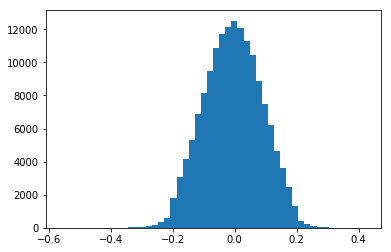

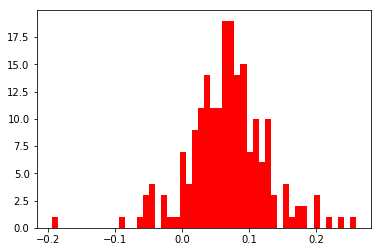

-0.01125606894493103 -0.010591013854445646 0.09559338451280304 -0.43290892243385315 0.39614108204841614 40000


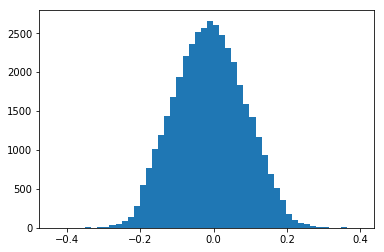

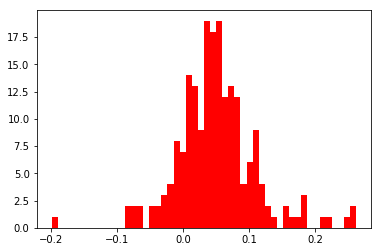

-0.009291781578212976 -0.009103562288500382 0.09272670544488557 -0.3566272258758545 0.3422996997833252 40000


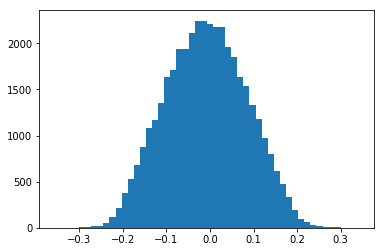

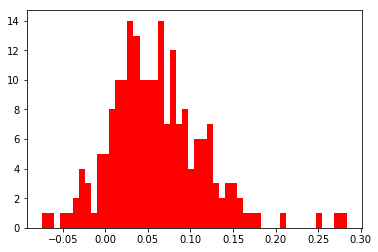

-0.009387338068336248 -0.009099776713227948 0.0918386088039359 -0.38987523317337036 0.3740573525428772 40000


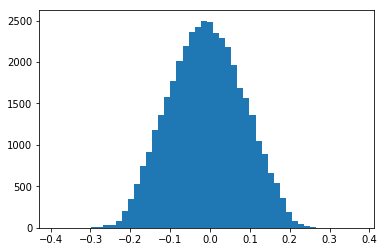

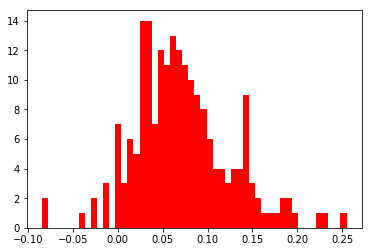

-0.011041231919080019 -0.010434791431998429 0.09146548290431747 -0.4013541638851166 0.32380029559135437 40000


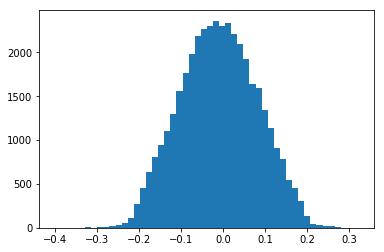

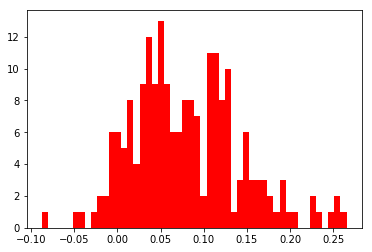

0.006929047405719757 0.0007412606873112963 0.1640711646865004 -1.093326449394226 0.6608792543411255 2000


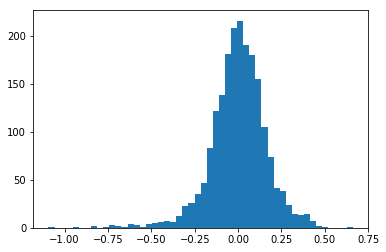

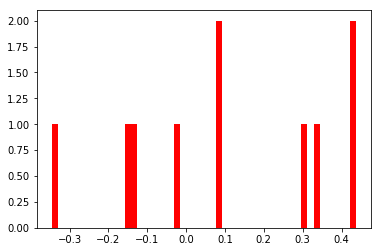

In [71]:
netname = 'mnist_nets/mnist_relu_6_200.txt'
epsilon = 0.01
specname = 'mnist_images/img0.txt'
#Import and parse the net
with open(netname, 'r') as netfile:
    netstring = netfile.read()
with open(specname, 'r') as specfile:
    specstring = specfile.read()
nn = parse_net(netstring)

for W, b in zip(nn.weights, nn.biases):
    print(np.median(W), W.mean(), W.std(), W.min(), W.max(), np.count_nonzero(W))
    plt.hist(W.flatten(),bins=50)
    plt.show()
    plt.hist(b.flatten(),bins=50, color='red')
    plt.show()

0.00018248341802975 0.00021846480525809529 0.0375373690653271 -0.2254219502210617 0.3039573431015015 802816


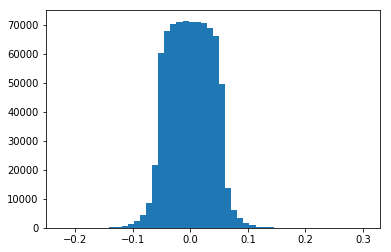

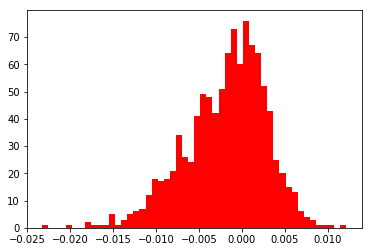

-0.00024071825464484997 -0.0001581227705596767 0.03299422682481596 -0.1277927160263062 0.1298308819532394 1048576


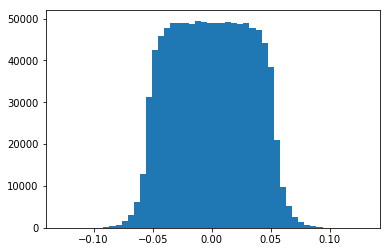

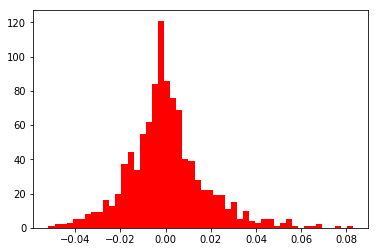

0.000456664187368 0.000490159545962561 0.032463972742364074 -0.1108156070113182 0.1191372200846672 1048576


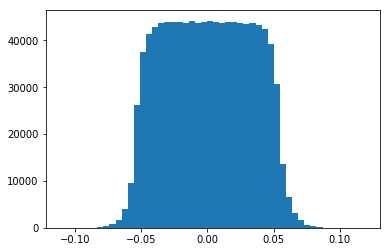

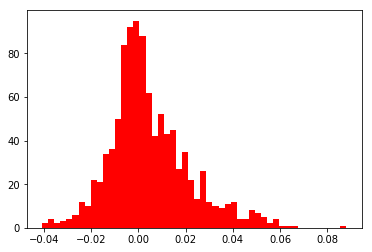

-0.00402022898197175 -5.185075959399719e-05 0.08980637853935786 -0.3177864849567413 0.3131057918071747 10240


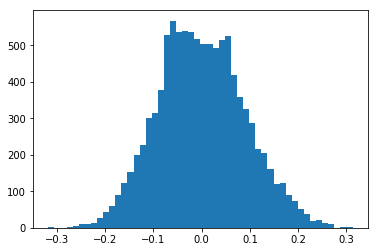

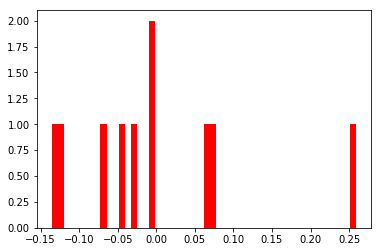

In [69]:
netname = 'mnist_nets/mnist_relu_4_1024.txt'
epsilon = 0.01
specname = 'mnist_images/img0.txt'
#Import and parse the net
with open(netname, 'r') as netfile:
    netstring = netfile.read()
with open(specname, 'r') as specfile:
    specstring = specfile.read()
nn = parse_net(netstring)

for W, b in zip(nn.weights, nn.biases):
    print(np.median(W), W.mean(), W.std(), W.min(), W.max(), np.count_nonzero(W))
    plt.hist(W.flatten(),bins=50)
    plt.show()
    plt.hist(b.flatten(),bins=50, color='red')
    plt.show()

In [11]:
netname = 'mnist_nets/mnist_relu_6_100.txt'
epsilon = 0.01
specname = 'mnist_images/img0.txt'

In [56]:
netname = 'mnist_nets/mnist_relu_3_20.txt'
epsilon = 0.01
specname = 'mnist_images/img1.txt'

In [66]:
def load_problem(netname, epsilon, specname):
    #Import and parse the net
    with open(netname, 'r') as netfile:
        netstring = netfile.read()
    with open(specname, 'r') as specfile:
        specstring = specfile.read()
    nn = parse_net(netstring)
    x0_low, x0_high = parse_spec(specstring)
    LB_N0, UB_N0 = get_perturbed_image(x0_low,0)
    label, _ = analyze(nn,LB_N0,UB_N0,0)
    LB_N0, UB_N0 = get_perturbed_image(x0_low,epsilon)
    assert(LB_N0.shape == UB_N0.shape)
    return nn, LB_N0, UB_N0, label

def initialize_box(nn, LB_N0, UB_N0, label):
    iobj = interval_object(LB_N0, UB_N0)
    iobj.fit(nn)
    return iobj

In [278]:
def analyze_v2(netname, epsilon, specname, iobj=None):
    verified = False
    nn, LB_N0, UB_N0, label = load_problem(netname, epsilon, specname)

    varis = {}
    keepers_all = {}

    if iobj is None:
        iobj = initialize_box(nn, LB_N0, UB_N0, label)
        if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, 0, label

    #set up gurobi model
    model = Model("net")
    model.setParam('OutputFlag', False)

    #add layer 0
    for dim_n in range(len(LB_N0)):
        x_0n  = model.addVar(LB_N0[dim_n], UB_N0[dim_n], name="x_0_"+str(dim_n))
        # Add the input variables to variable dict for later access under name x_0_n
        varis['x_0_'+str(dim_n)] = x_0n

    #add layer 1:
    add_layer(1, nn, iobj, varis, keepers_all, keep_perc = 0)

    #add layer 2:
    for layer_k in range(2,nn.numlayer):
        add_layer(layer_k, nn, iobj, varis, keepers_all, with_opt=True, keep_perc=0)
        iobj.fit(nn,layer_k)
        if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, layer_k, label
        #add_layer(layer_k, nn, iobj, varis, keepers_all, with_opt=True, keep_perc=0.5)
        #iobj.fit(nn,layer_k)
        #if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, layer_k, label

In [279]:
netname = 'mnist_nets/mnist_relu_6_50.txt'
epsilon = 0.01
specname = 'mnist_images/img1.txt'

In [280]:
%time analyze_v2(netname, epsilon, specname)

Fraction kept: 1.0
Fraction kept: 1.0


AttributeError: b"Unable to retrieve attribute 'X'"

In [217]:
iobj = None
verified = False
nn, LB_N0, UB_N0, label = load_problem(netname, epsilon, specname)

varis = {}
keepers_all = {}

if iobj is None:
    iobj = initialize_box(nn, LB_N0, UB_N0, label)
    #if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, relu_bins, 0, label

#set up gurobi model
model = Model("net")
model.setParam('OutputFlag', False)

#add layer 0
for dim_n in range(len(LB_N0)):
    x_0n  = model.addVar(LB_N0[dim_n], UB_N0[dim_n], name="x_0_"+str(dim_n))
    # Add the input variables to variable dict for later access under name x_0_n
    varis['x_0_'+str(dim_n)] = x_0n
        
#add layer 1:
#Find relevant relus:
add_layer(1, nn, iobj, varis, keepers_all)

#add layer 2:
add_layer(2, nn, iobj, varis, keepers_all, with_opt=True)
iobj.fit(nn,2)
#if prove(*iobj.get_bounds(layer_k=nn.numlayer),label)[1]: return True, iobj, relu_bins, layer_k, label

(array([0.        , 0.        , 5.75801389, 0.        , 0.        ,
        0.        , 0.73831468, 0.        , 0.        , 0.        ]),
 array([1.49994974, 2.61307405, 9.82515045, 2.00842248, 0.        ,
        2.41630195, 4.91897979, 0.        , 0.        , 0.        ]))

In [249]:
def update_layer(layer_k, nn, iobj, varis, keepers_all, with_opt=True):
    '''Still todo'''
    print('*')
    W = nn.weights[layer_k]
    xl, xu = iobj.get_bounds(layer_k)
    keepers = get_relevant_relus(W, xu, keep_perc)
    keepers_all[layer_k] = keepers
    print('*')

In [264]:
def add_layer(layer_k, nn, iobj, varis, keepers_all, with_opt = False, keep_perc = 0.1):
    #add layer k:
    #Find relevant relus:
    W = nn.weights[layer_k]
    xl, xu = iobj.get_bounds(layer_k)
    keepers = get_relevant_relus(W, xu, keep_perc)
    keepers_all[layer_k] = keepers

    #add relevant relus:
    layer_type, weights, biases = get_layer(layer_k-1, nn)
    out_dim, in_dim = weights.shape
    hl, hu = iobj.get_logit_bounds(layer_k-1)
    xl, xu = iobj.get_bounds(layer_k)
    assert hl.size == out_dim
    assert xl.size == out_dim       # The x's are ReLU(h)

    for dim_m in range(len(xu)):
        if xu[dim_m] <= 0:
            varis['x_'+str(layer_k)+'_'+str(dim_m)] = 0 
            continue

        ws = weights[dim_m,:]  #one row of weights
        b  = biases[dim_m]

        if dim_m in keepers:
            h_km = LinExpr(b)
            for dim_n in range(in_dim):
                h_km.add( ws[dim_n] * varis['x_'+str(layer_k-1)+'_'+str(dim_n)] )

            # Activation
            if layer_type == 'ReLU':
                x_km, flag, constraints = relu_split(model, layer_k, dim_m, 
                                                  h_lb=hl[dim_m], h_ub=hu[dim_m], x_lb=xl[dim_m], x_ub=xu[dim_m], 
                                                  h_km=h_km) 
            
            if with_opt:
                out_ws = np.array(nn.weights[layer_k])[:,dim_m]
                max_out_weight = max(abs(out_ws))

                new_lb, new_ub = tighten_bounds(model, x_km, flag, xl[dim_m], xu[dim_m], hl[dim_m], h_km, constraints,
                                               abs_tol= layer_k**3/(100*max_out_weight*len(keepers)) )
                
                assert new_lb >= xl[dim_m] - 1e-7
                assert new_ub <= xu[dim_m] + 1e-7

                #UPDATE Layer k
                iobj.intervals['xl_'+str(layer_k)][dim_m] = new_lb
                iobj.intervals['xu_'+str(layer_k)][dim_m] = new_ub
                
        else:
            x_km  = model.addVar(xl[dim_m], xu[dim_m], name='x_'+str(layer_k)+'_'+str(dim_m))
        varis['x_'+str(layer_k)+'_'+str(dim_m)] = x_km 
    

In [265]:
def get_relevant_relus(W, xu, keep_perc=0.2):
    keepers = np.array([])
    out_dim , in_dim = W.shape
    for i in range(out_dim):
        summands = abs(W[i,:] * xu)
        max_contribution = max(summands)

        keepers = np.union1d(keepers, np.nonzero(summands >= keep_perc * max_contribution)[0])
    print('Fraction kept:', len(keepers)/in_dim)
    return keepers.astype(int)

In [157]:
def get_layer(layer_k, nn):
    # Get weights, biases & layertype from nn
    layer_type = nn.layertypes[layer_k]
    weights = np.array(nn.weights[layer_k])
    biases = np.array(nn.biases[layer_k])
    
    return layer_type, weights, biases

In [ ]:
netname = 'mnist_nets/mnist_relu_6_200.txt'
epsilon = 0.01
specname = 'mnist_images/img1.txt'

In [144]:
%%time 

135